In [ ]:
%matplotlib widget

import heartpy as hp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import pyxdf
import systole

#Directory where data is located (change this to where you will store your data)
dir_data = 'data'

#XDF,CSV,etc file names
file_format = 'vrcct_%s_%s_%s.%s'

#Subject Identifiers: 
subjects = ['p16']

#Study Identifier: 
studies = ['prestudy']

#Experiment Part: 
parts = ['prebaseline','condition']

#Directories we need to use
dir_data = 'data'
dir_xdf = os.path.join(dir_data,'xdf')

plt.style.use('ggplot')

# __1 Electrocardiogram (ECG)__

An electrocardiogram (ECG or EKG) records electrical signals that lead to the heart muscle contractions using electrodes attached to the body. The most notable feature of an ECG is the QRS-complex (see below). 

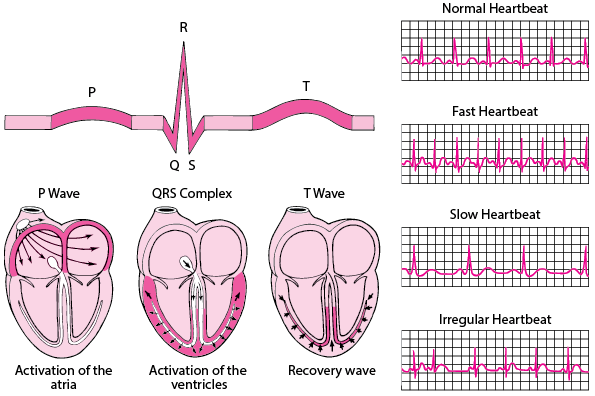

The R-peak has the largest amplitude, and when extracting heart beats, these peaks are usually marked in the ECG. Because of this, ECG provides a good signal-to-noise ratio. 

The accuracy of peak detection is very important in some aspects of ECG analysis. __For calculating heart rate (BPM), accurate peak detection is not crucial__. This is because it is an aggregate measure as it is calculated as the average beat-to-beat interval across the entire analyzed signal, making it robust to outliers. __Accurate peak detection is crucial when extracting heart rate variability (HRV) measures__. Two HRV metrics include RMSSD (root mean square of successive differences) and the SDSD (standard deviation of successive differences). RMSSD is calculated as shown in the figure below: 

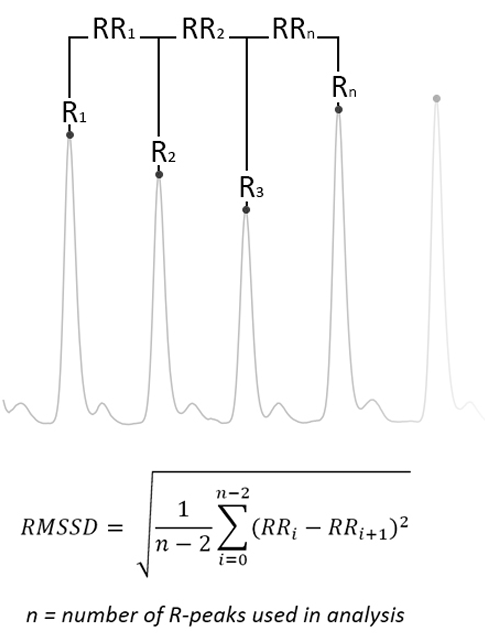

Consider two inaccuracies of peak detection algorithms: 1) a missed peak/beat and 2) a extra peak/beat detected incorrectly. These artifacts will have a large effect on HRV. These HRV metrics are sensitive to outliers because they are designed to capture the slight natural variance between peak-to-peak intervals in the ECG. __It seems that incorrect peak/beat placements far outweight those of missing peaks when it comes to affecting HRV metrics (not so much BPM as it is robust to outliers)__. 

Most of this information is from [heartpy's documentation](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/heartrateanalysis.html#on-the-accuracy-of-peak-position). There are terrific Python packages that can aid us in our ECG analysis like [heartpy](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/index.html), [systole](https://www.the-ecg.org/post/systole-a-python-package-for-processing-analyzing-and-synchronizing-cardiac-data), and [neurokit](https://github.com/neuropsychology/NeuroKit), which we use. However, there are other [tutorials](https://www.kaggle.com/code/stetelepta/exploring-heart-rate-variability-using-python) you can look at if you want more information in ECG analysis in addition to what you will be learning in this Jupyter Notebook. 

# __Main Points__

1. Naming conventions are very important in analysis as they allow us to for-loop our pipeline easily. 
2. Processing/Analysis Pipeline: 1) apply bandpass filter (to remove any motion, muscle, line noise, or baseline wander), 2) apply peak detection algorithm (Pan-Tompkins; optionally we can correct interbeat intervals using [Lipponen et al. artifact detection/correction](https://pubmed.ncbi.nlm.nih.gov/31314618/)), and 3) Calculate HRV metrics.

3. While we can automate our pipeline, it does not remove all noise/artifacts. As we have discussed, HRV is sensitvie to peak detection inaccuracies, so manually detecting peak is the golden standard. 

## __os - Miscellaneous operating system interfaces__

If you haven't worked with loading in files, the Python module __os__ may be new. This module provides ways of using operating system dependent functionality. Your operating system will determine how your paths will be structured: 

1. For windows, there are drives, backslashes or double backslashes: "C:\Users\JohnSmith" or "C:\\Users\\JohnSmith"
2. For Linus, you don't have the typical drives as in Windows, but use forward slashes: "/home/JohnSmith"

This is where the Python module os comes in. It allows us to combine strings into a proper path used by your operating system. Rather than guessing if you use a backslash or foward slash (or writing Python code that may be used for other people with different operating systems), you can use os to always have the correct path structure. One function you will see here is __os.path.join__. I encourage you to read the [documentation](https://docs.python.org/3/library/os.path.html). Moreover, you do more than create paths to files. You can check if a file exist (__os.path.isfile__), check if a directory exists (__os.path.isdir__), create new directory (__os.mkdir__), or list all files in a directory (__os.listdir__). 

# __1. Overview/Naming Convention__

One important aspect in recording your experiments that can be overlooked is how the recordings are named. Consistency in naming is key because with programming you can load in files with ease. Our recordings have a naming scheme as shown below: 

__<center>vrcct_SUBJECT_STUDY_DESCRIPTION.xdf</center>__

Each recording has a __SUBJECT__ identifier (or participant identifier) like __p4__ and a one word __DESCRIPTION__ of what part of the experiment was recorded (i.e., __condition__ for when the subject meditated, __prebaseline__ before the subject meditated, and a __postbaseline__ after the subject meditated). Each recording is from a STUDY--prestudy and poststudy--indicating if the subject completed the mediation course. With this information, we will separate these types of recordings and save them as csv files. That is why we created the __file format__ variable to help us in loading/saving the ECG data. The %s in their name can be used substitute any string we want it to. We will see later how this is used.

However, for these particular datasets, we only have one EEG stream (along with an event code stream) and there is no dedicated stream for ECG. Our ECG data is part of EEG stream. In fact, they are on external channels 1 and 2 which corresponds to __channels 66 and 67__ of the EEG stream. This may change if we get a dedicated ECG device, so we will worry about that when the time comes. These channels (66 and 67) correspond to electrode placement on the left and right collarbone (below it), respectively. This corresponds to Lead I.

One caveat to this analysis is that we do have sections of the recordings we are very interested that are marked by event markers. We do not go over extracting these sections, and I will write a separate Jupyter Notebook as its a bit more complicated to perform. For now, we will focus on processing. 

# 2 __Processing Pipeline__

Let's get to it. Our subjects move around a little to control their movement in the VR space. Therefore, we will have some muscle noise (caused by moving), baseline wander (caused by perpiration, respiration, movement, or poor electrode contact), and possibly power line interference (AC electrical noise). We will use a bandpass filter to get rid of most of this noise. It is very simple to implement it, and we will use a heartpy function __filter_signal__ to perform it. We will only use the left electrode (channel 66).

__Please take note on how easily we can load in data using the consistent file naming convention. With a simple for-loop, you can easily process all your datasets (assuming there are no complications in loading our data).__

I have included two datasets: one ideal one and the other not so ideal (we have to invert the signal). In the following code cell, ECG data is normalized using the heartpy.scale_data function that (as the function name suggests) scales the data from 0 to 1024. Note that units don't matter when dealing with ECG. All we want is where the peaks are (not their amplitude). 

In [ ]:
# Please refer to the top cell of subjects we can process
#Additionally, you can look at the data folder where this notebook is located in

#Subject, study, and part of experiment are defined: 
sub = subjects[0] # subject/participant 16
study = studies[0] # prestudy before participant took the compassion training
part = parts[0] #baseline prior to start of experiment

print(sub,study,part)

#Loading in EEG and extracting ECG: 
EEG_stream,_ = pyxdf.load_xdf(
    os.path.join(dir_xdf,file_format%(sub,study,part,'xdf')),
    select_streams=[{'type':'EEG'}]
)

#Extracting raw ECG:
ECG_raw = EEG_stream[0]['time_series'][:,65]
ECG_ts = EEG_stream[0]['time_stamps']
srate = round(EEG_stream[0]['info']['effective_srate']) 

#Applying a Bandpass filter from 2 Hz to 30 Hz: 
ECG_clean = hp.filter_signal(
    ECG_raw,
    sample_rate=srate,
    cutoff=[2,30],
    filtertype='bandpass'
)  



## 2.1 Plotting Clean and Raw ECG

By just applying a bandpass filter between (2 Hz to 30 Hz), we have pretty clean data (in green). We removed the baseline wander and have accentuated our peaks. Next we will use the Neurokit peak detection algorithm. 

In [ ]:
#Figure and Axes 
fig,ax = plt.subplots(
    figsize=(10,4),
    sharex=True,sharey=True,
    constrained_layout=True
)

#Plotting raw and clean ECG:
ax.plot(
    ECG_ts,hp.scale_data((ECG_raw)),
    'r',zorder=2,label='Raw'
)
ax.plot(
    ECG_ts,hp.scale_data((ECG_clean)),
    'g',zorder=1,label='Clean'
)

#Titles and labels
ax.set_title(
    "Comparing %s_%s_%s Raw and Clean ECG: Please Zoom in and Scroll!"%(sub,study,part),
    fontsize=15
)
ax.set_xlabel('LSL Time (seconds)',fontsize=18)
ax.set_ylabel('ECG (Arbitrary Units)',fontsize=18)

#Legend
ax.legend(
    loc='center left',
    bbox_to_anchor=(1,0.5),
    fancybox=True,
    shadow=True
)

# 3 Analysis: Peak Detection

Peak detection algorithm are used to detect QRS complexes in ECG. As have been said earlier, R-peaks are prominent in the QRS complex, so these peak detection algorithms usually detect these R-peaks. When we have locations of these peaks, we can calculate inter-beat intervals (R-R intervals), the time between adjacent peaks (usually in milliseconds). With these R-R intervals, we can calculate heart rate and heart rate variability. We usually filter the ECG to increase the signal-to-noise ratio and then apply the peak detection algorithm. We use the function __neurokit2.ecg_peaks__ and with this function, we can apply a variety of algorithms (each with their advantages and disadvantages): 'neurokit', 'pantompkins1985','nabian2018', 'gamboa2008', 'zong2003', 'hamilton2002', 'christov2004', 'engzeemod2012', 'elgendi2010', 'kalidas2017', 'martinez2003', 'rodrigues2021' or 'promac'. You can use the __?nk.ecg_peak__ to find the references for these algorithms. We will use the default 'neurokit' algorithm. We do not use the [Lipponen et al. Artifact Detection/Correction algorithm](https://pubmed.ncbi.nlm.nih.gov/31314618/) and set the __correct_artifact__ argument as False. The output is a Pandas Series of a 0s and 1s, where 1 indicate peaks. 

In [ ]:
#Neurokit Peak Detection
peaks, info = nk.ecg_peaks(
    ECG_clean,
    sampling_rate=srate,
    method='neurokit',
    correct_artifacts=False
)

#Converting to boolean array
peaks = peaks.values.reshape(len(peaks)).astype(bool)

## 3.1 Plotting Peaks Detected

We see that the peak algorithm did pretty well (with the exception of the first peak), but that shouldn't be a concern. Next we can use these peaks to determine some ECG metrics. 

In [ ]:
#Figure and Axes 
fig,ax = plt.subplots(
    figsize=(10,4),
    sharex=True,
    constrained_layout=True
)

#Plotting Clean data with peaks detected
ax.plot(
    ECG_ts,hp.scale_data((ECG_clean)),
    'g',label='Clean ECG'
)
ax.plot(
    ECG_ts[peaks],
    hp.scale_data(ECG_clean)[peaks],
    ms=10,marker=matplotlib.markers.CARETDOWN,
    color='r',linestyle='None',
    label='Peaks'
)

#Plot title and Axes Labels
ax.set_title(
    "%s_%s_%s Clean ECG: Peak Detection"%(sub,study,part),
    fontsize=18
)
ax.set_xlabel('LSL Time (seconds)',fontsize=18)
ax.set_ylabel('ECG (Arbitrary Units)',fontsize=18)


#Legend
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.,0.5),
    fancybox=True,
    shadow=True
)

## 4 Analysis: RR Intervals

Interbeat (R-R or N-N) Intervals are caculated by finding the time between peaks. Because our peaks variable is a boolean/logic array, we can use it to find the time of each peak and use the function __numpy.diff__ to calculate interbeat intervals. After calculating, we can plot them and see what the interbeat interval is between each peak. 

In [ ]:
#Calculating RR peaks
rr = np.diff(ECG_ts[peaks])*1000 # in milliseconds

#Indices where we can plot RR conveniently in conjunction with ECG
ind = np.where(peaks)[0][:-1]+np.around(np.diff(np.where(peaks)[0])/2).astype(int)
rr_ts = ECG_ts[ind]


#Figure and Axes 
fig,ax1 = plt.subplots(
    figsize=(10,4),
    sharex=True,
    constrained_layout=True
)


#####Plotting Clean ECG and Peaks#####
ax1.plot(
    ECG_ts,hp.scale_data((ECG_clean)),
    'g',label='Clean ECG'
)
ax1.plot(
    ECG_ts[peaks],
    hp.scale_data(ECG_clean)[peaks],
    ms=10,marker=matplotlib.markers.CARETDOWN,
    color='r',linestyle='None',
    label='Peaks'
)
#just a place holder for the legend
ax1.plot(np.nan,np.nan,'k-o',label='RR') 

#Titles and labels for ECG Plot
ax1.grid(False) #don't need units
ax1.set_title(
    "%s_%s_%s Clean ECG: RR Interval"%(sub,study,part),
    fontsize=18
)
ax1.set_xlabel('LSL Time (seconds)',fontsize=18)
ax1.set_ylabel('ECG (Arbitrary Units)',fontsize=18,color='green')
ax1.set_yticklabels([])
ax1.tick_params(axis='y',labelcolor='green')

#Legend
ax1.legend(
    loc='center left',
    bbox_to_anchor=(1.10,0.5),
    fancybox=True,
    shadow=True
)


#####Plotting RR Intervals#####
ax2 = ax1.twinx() #We use a twin axes to plot them simultanously
ax2.plot(rr_ts,rr,'k-o')

#Titles and labels for RR-Interval
ax2.grid(True,which='major',color='black',linestyle='-')
ax2.set_ylabel('R-R Interval (ms)',fontsize=18,color='black')
ax2.tick_params(axis='y',labelcolor='black')

# 5 Analysis: Calculating HRV

We can use the __Python Package Systole__ and their HRV calculation functions. Then we can organize and display our results as a Pandas DataFrame. We have three different domains we can calculate HRV from. 

For __time domain HRV metrics__, either the heart rate at any ppiont in time or the intervals between sussive normal complexes are determined. The most important time domain metric is the root mean square of successive differences (RMSSD), which reflects the strength of the autonomic nervous system (particularly the parasympathetic system). There is research showing that [it decreases during mantra meditation](https://www.frontiersin.org/articles/10.3389/fnhum.2015.00145/full) and [is impacted by stress](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5900369/). 

__Frequency domain HRV metrics__ shows how much of our RR signals lies within one or more frequency bands. There some certified frequency bands that correlate with parasympathetic nervous system activity. These bands may have different interpretation on how they affect the autonomic nervous system (There is a reference at the end to read more on them). The frequency bands include: 

1. Very low Frequency (VLF): frequency activity within the 0-0.04 Hz range
2. Low Frequency (LF): frequency activity within the 0.4-0.15 Hz range
3. High Frequency (HF): frequency activity within the 0.15-0.40 Hz range

__Non-linear domain HRV metrics__ include SD1 and SD2. You can read more in the reference below at the end. Poincare plots can be used to visualized SD1 and SD2. There is [research](https://biomedical-engineering-online.biomedcentral.com/articles/10.1186/1475-925X-10-96) that use these metrics to detect real-life stress conditions (e.g. university exams). 

To get more information on these HRV metrics, here is [good reference](https://www.frontiersin.org/articles/10.3389/fpubh.2017.00258/full). 

## 5.1 Time Domain

In [ ]:
df_timeDomain = systole.hrv.time_domain(rr)
df_timeDomain

## 5.2 Frequency Domain

In [ ]:
df_freqDomain = systole.hrv.frequency_domain(rr)
df_freqDomain

## 5.3 Non-linear Domain

In [ ]:
df_nonlinearDomain = systole.hrv.nonlinear_domain(rr)
df_nonlinearDomain

### 5.3.1 Poincare Plot

In [ ]:
#Figure and Axes 
fig,ax = plt.subplots(
    figsize=(7,5),
    sharex=True,
    constrained_layout=True
)

#Previous RR and Next RR
rr_n = rr[:-1]
rr_n1 = rr[1:]

#Extracting SD1 and SD2
sd1 = df_nonlinearDomain.loc[0,'Values']
sd2 = df_nonlinearDomain.loc[1,'Values']

#Plotting previous and next RR
ax.scatter(rr_n,rr_n1,color="#51A6D8")

#Ellipse defined by SD1 and SD2
e = Ellipse((np.mean(rr),np.mean(rr)),2*sd1,2*sd2,angle=-45,linewidth=1.2,fill=False,color="k")
plt.gca().add_patch(e)

#Arrows denoting sd1 and sd2: 
ax.arrow(np.mean(rr),np.mean(rr), -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=4,label='SD1')
ax.arrow(np.mean(rr),np.mean(rr), sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=4,label='SD2')


#Titles and Axes Labels: 
ax.set_title('Poincare Plot',fontsize=20)
ax.set_xlabel(r'$RR_n (ms)$',fontsize=18)
ax.set_ylabel(r'$RR_{n+1} (ms)$',fontsize=18)

#legend:
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.10,0.5),
    fancybox=True,
    shadow=True
)

# Conclusion

__So what can we do with these metrics?__ That's a good question and it depends on our research question. This dataset is from our VRCCT study in which each subject attended two sessions (prestudy and poststudy). In the prestudy, our subject had their baseline and a guided meditation in VR. We have several subjects, so we can run some inferential statistics (ANOVA, t-test, etc.) to see if VR guided meditation affected any of these HRV metrics. We additionally recorded EEG from these subjects and may find relationships between ECG and EEG. We only looked at the baseline, but there is another dataset when the subject was in the VR guided meditation (vrcct_p16_prestudy_condition.xdf). See if you can modify the code above to process and analyze it. 